In [33]:
import pandas as pd
from tdc.multi_pred import DDI
from tdc.utils import get_label_map
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from rdkit import DataStructs


In [34]:

# Load dataset
data = DDI(name='DrugBank')
df = data.get_data()

print("Initial data size:", df.shape)
print("Label distribution:\n", df['Y'].value_counts())


Found local copy...
Loading...
Done!


Initial data size: (191808, 5)
Label distribution:
 Y
49    60751
47    34360
73    23779
75     9470
60     8397
      ...  
28       11
1        11
52       10
26        7
42        6
Name: count, Length: 86, dtype: int64


In [35]:
df = df.sample(n = 50000, random_state=42).reset_index(drop=True)

In [36]:
# Minimum samples per class to keep
min_samples = 5

counts = df['Y'].value_counts()
valid_classes = counts[counts >= min_samples].index

df = df[df['Y'].isin(valid_classes)].reset_index(drop=True)

print(f"Data size after filtering rare classes (<{min_samples} samples):", df.shape)
print("New label distribution:\n", df['Y'].value_counts())


Data size after filtering rare classes (<5 samples): (49985, 5)
New label distribution:
 Y
49    15784
47     8910
73     6377
75     2428
60     2160
      ...  
46        7
79        6
7         5
62        5
41        5
Name: count, Length: 78, dtype: int64


In [37]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def mol_to_morgan_fp(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((n_bits,), dtype=int)  # handle invalid SMILES
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


In [38]:
# --- Step 4: Generate fingerprints ---
print("Generating Morgan fingerprints for Drug1...")
df['Drug1_fp'] = df['Drug1'].apply(mol_to_morgan_fp)
print("Generating Morgan fingerprints for Drug2...")
df['Drug2_fp'] = df['Drug2'].apply(mol_to_morgan_fp)

Generating Morgan fingerprints for Drug1...
Generating Morgan fingerprints for Drug2...


In [39]:
# --- Step 5: Prepare features by concatenating ---
X = np.array([np.concatenate([fp1, fp2]) for fp1, fp2 in zip(df['Drug1_fp'], df['Drug2_fp'])])


In [40]:
# --- Step 6: Encode labels ---
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Y'])
print(f"Number of classes: {len(label_encoder.classes_)}")


Number of classes: 78


In [41]:
# --- Step 7: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [42]:
# --- Step 8: Train XGBoost multi-class model ---
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    use_label_encoder=False,
    eval_metric='mlogloss'
)



In [43]:
print("Training model...")
model.fit(X_train, y_train)

Training model...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=78, ...)

In [44]:
# --- Step 9: Evaluate ---
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in label_encoder.classes_]))

              precision    recall  f1-score   support

           2       0.69      0.47      0.56        19
           3       0.90      1.00      0.95        26
           4       0.73      0.78      0.75       260
           5       0.80      0.75      0.77        16
           6       0.84      0.92      0.88       161
           7       1.00      1.00      1.00         1
           8       0.64      0.82      0.72        11
           9       0.90      0.90      0.90       105
          10       0.87      0.81      0.84        32
          11       0.70      0.44      0.54        16
          12       0.89      0.67      0.76        12
          13       1.00      0.33      0.50         3
          14       0.93      0.82      0.88        17
          15       1.00      0.89      0.94         9
          16       0.89      0.94      0.92       285
          17       0.75      0.75      0.75         4
          18       1.00      0.20      0.33         5
          19       0.75    

In [45]:
# 1. Get a new sample that does not overlap with training data
# Assume df_all is the full original dataset before sampling
df_all = data.get_data()
used_indices = df.index  # indices used for training
available_indices = df_all.index.difference(used_indices)


In [46]:
available_indices

RangeIndex(start=49985, stop=191808, step=1)

In [59]:
# Sample a different 5,000-row test set from the rest
df_test = df_all.loc[available_indices].sample(n=10000, random_state=24).reset_index(drop=True)


In [60]:
# 2. Preprocess the new test set
# Remove rows with invalid SMILES
mask_valid = df_test['Drug1'].apply(lambda x: Chem.MolFromSmiles(x) is not None) & \
             df_test['Drug2'].apply(lambda x: Chem.MolFromSmiles(x) is not None)
df_test = df_test[mask_valid].reset_index(drop=True)


In [61]:
# Generate fingerprints
df_test['Drug1_fp'] = df_test['Drug1'].apply(lambda x: np.array(mol_to_morgan_fp(x)))
df_test['Drug2_fp'] = df_test['Drug2'].apply(lambda x: np.array(mol_to_morgan_fp(x)))


In [62]:
df_test

,Drug1_ID,Drug1,Drug2_ID,Drug2,Y,Drug1_fp,Drug2_fp
0,DB09068,CC1=CC=C(SC2=CC=CC=C2N2CCNCC2)C(C)=C1,DB00768,CN(C)CC\C=C1\C2=CC=CC=C2COC2=C1C=C(CC(O)=O)C=C2,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,DB06737,CC(C(O)=O)C1=CC=C2SC3=C(C=CC=C3)C(=O)CC2=C1,DB00310,NS(=O)(=O)C1=C(Cl)C=CC(=C1)C1(O)NC(=O)C2=CC=CC...,70,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,DB00564,NC(=O)N1C2=CC=CC=C2C=CC2=CC=CC=C12,DB09224,CC1CCN(CCCC(=O)C2=CC=C(F)C=C2)CC1,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,DB08893,NC1=NC(CC(=O)NC2=CC=C(CCNC[C@H](O)C3=CC=CC=C3)...,DB00169,CC(C)CCC[C@@H](C)[C@@]1([H])CC[C@@]2([H])\C(CC...,47,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,DB00244,NC1=CC(C(O)=O)=C(O)C=C1,DB08906,[H][C@@]12C[C@@H](C)[C@](OC(=O)C3=CC=CO3)(C(=O...,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
9995,DB09218,CC1=C(NC2=C(C=CC=N2)C(O)=O)C=CC=C1Cl,DB00223,[H][C@@]12C[C@H](C)[C@](O)(C(=O)CO)[C@@]1(C)C[...,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9996,DB00402,CN1CCN(CC1)C(=O)O[C@@H]1N(C(=O)C2=NC=CN=C12)C1...,DB01433,CCC(OC(C)=O)C(CC(C)N(C)C)(C1=CC=CC=C1)C1=CC=CC=C1,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9997,DB00474,CCC#CC(C)C1(CC=C)C(=O)NC(=O)N(C)C1=O,DB00341,OC(=O)COCCN1CCN(CC1)C(C1=CC=CC=C1)C1=CC=C(Cl)C=C1,49,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
9998,DB09225,CN(C)CCOC1=CC2=CC=CC=C2SC2=CC=C(Cl)C=C12,DB01501,OC(=O)C1(CCN(CCC(C#N)(C2=CC=CC=C2)C2=CC=CC=C2)...,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [63]:
# Concatenate fingerprints
X_test = np.array([np.concatenate([fp1, fp2]) for fp1, fp2 in zip(df_test['Drug1_fp'], df_test['Drug2_fp'])])


In [64]:
# Encode labels using the same label encoder from training
# Unseen classes will cause errors, so filter to known classes only
df_test = df_test[df_test['Y'].isin(label_encoder.classes_)].reset_index(drop=True)
X_test = X_test[:len(df_test)]  # Align X and y
y_test = label_encoder.transform(df_test['Y'])


In [65]:
# 3. Predict and evaluate
y_pred = model.predict(X_test)

In [66]:
from sklearn.metrics import classification_report
import numpy as np

print("📊 Evaluation on new sample:")
unique_labels = np.unique(y_test)
print(classification_report(
	y_test, y_pred,
	labels=unique_labels,
	target_names=[str(label_encoder.classes_[i]) for i in unique_labels]
))

📊 Evaluation on new sample:
              precision    recall  f1-score   support

          47       0.74      0.88      0.81      1296
          48       1.00      0.60      0.75         5
          49       0.91      0.92      0.92      4370
          51       1.00      0.83      0.91         6
          53       0.94      0.59      0.73        27
          54       1.00      0.92      0.96        99
          55       1.00      1.00      1.00         7
          56       0.50      1.00      0.67         1
          57       0.93      0.89      0.91        47
          58       0.94      0.99      0.96        79
          59       1.00      1.00      1.00         2
          60       0.88      0.79      0.84       545
          61       0.97      0.90      0.93        39
          62       1.00      0.50      0.67         2
          63       1.00      0.50      0.67         2
          64       0.91      0.66      0.76        59
          65       1.00      1.00      1.00         2

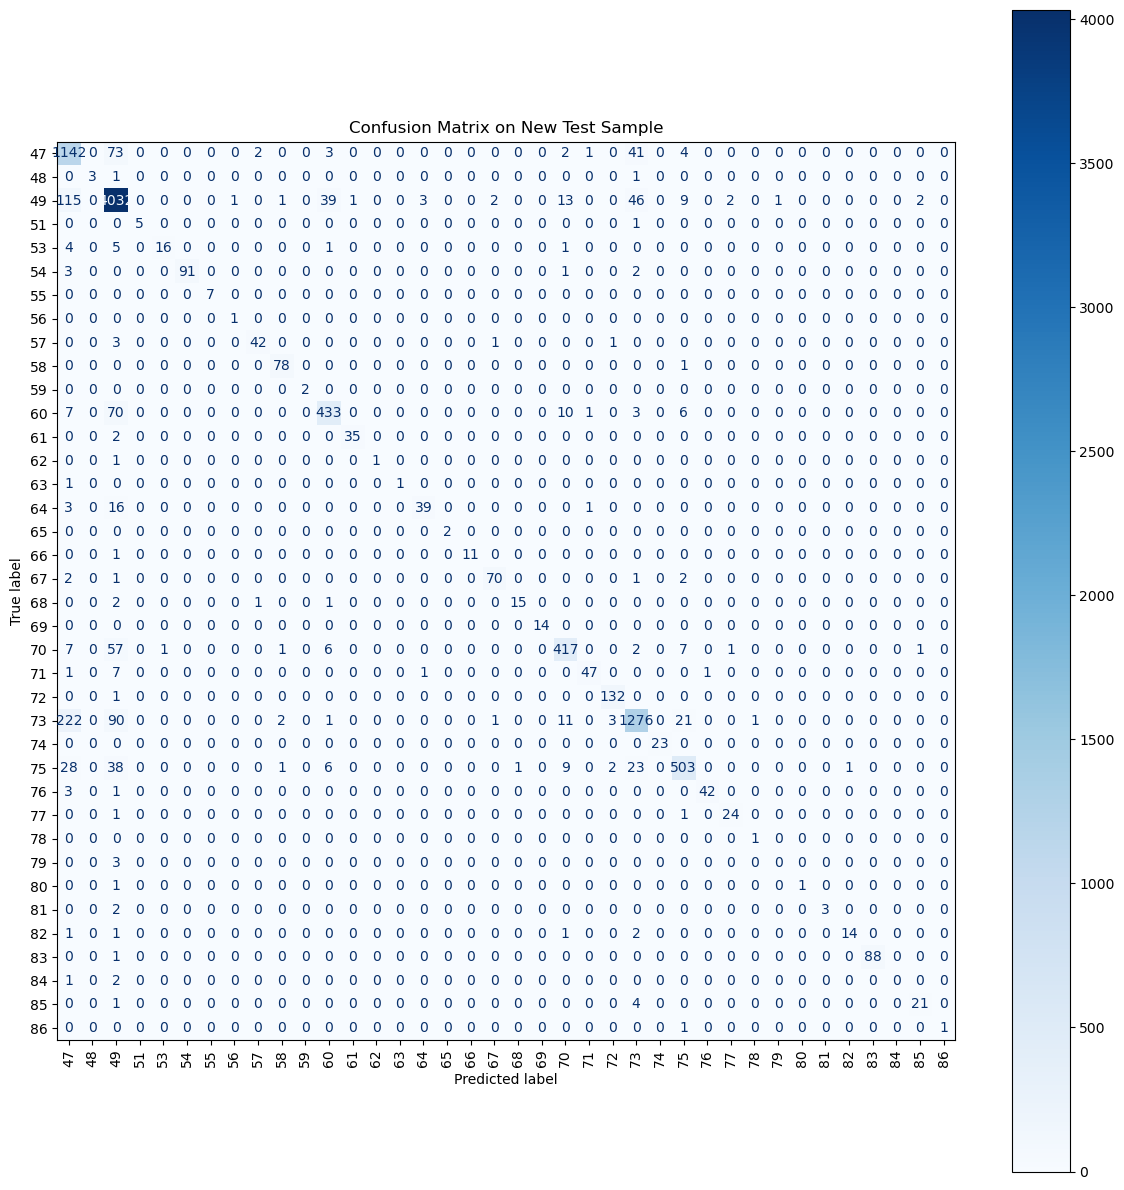

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute and plot confusion matrix for only present classes
unique_labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(label_encoder.classes_[i]) for i in unique_labels])
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Confusion Matrix on New Test Sample")
plt.tight_layout()
plt.show()


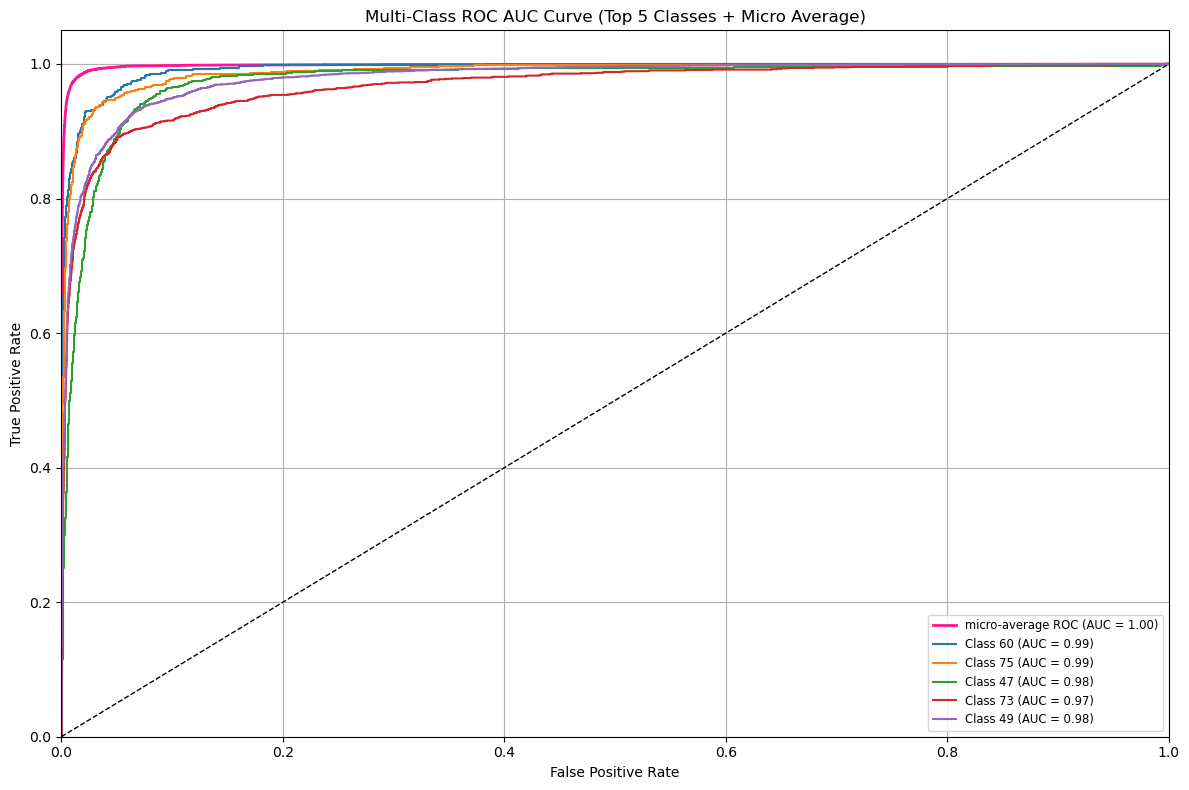

In [68]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get probabilities (required for ROC)
y_proba = model.predict_proba(X_test)

# Binarize the true labels
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Optionally compute micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for a few top classes
plt.figure(figsize=(12, 8))

# Plot micro-average
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linewidth=2)

# Plot ROC for top 5 most common classes
top_classes = np.argsort(np.bincount(y_test))[-5:]  # top 5 frequent class indices

for i in top_classes:
    label = label_encoder.classes_[i]
    plt.plot(fpr[i], tpr[i], lw=1.5, label=f'Class {label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC AUC Curve (Top 5 Classes + Micro Average)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [70]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Get confusion matrix for present classes only
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
class_names = label_encoder.classes_

# Initialize lists
sensitivity = []
specificity = []
ppv = []

print(f"{'Class':<20} {'TP':<4} {'FP':<4} {'FN':<4} {'TN':<6} {'Sens.':<8} {'Spec.':<8} {'PPV (VPP)':<10}")
print("-" * 70)

for idx, label in enumerate(unique_labels):
    TP = cm[idx, idx]
    FP = cm[:, idx].sum() - TP
    FN = cm[idx, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    sensitivity.append(sens)
    specificity.append(spec)
    ppv.append(precision)

    print(f"{class_names[label]:<20} {TP:<4} {FP:<4} {FN:<4} {TN:<6} {sens:<8.3f} {spec:<8.3f} {precision:<10.3f}")


Class                TP   FP   FN   TN     Sens.    Spec.    PPV (VPP) 
----------------------------------------------------------------------
47                   1142 398  126  8068   0.901    0.953    0.742     
48                   3    0    2    9729   0.600    1.000    1.000     
49                   4032 381  235  5086   0.945    0.930    0.914     
51                   5    0    1    9728   0.833    1.000    1.000     
53                   16   1    11   9706   0.593    1.000    0.941     
54                   91   0    6    9637   0.938    1.000    1.000     
55                   7    0    0    9727   1.000    1.000    1.000     
56                   1    1    0    9732   1.000    1.000    0.500     
57                   42   3    5    9684   0.894    1.000    0.933     
58                   78   5    1    9650   0.987    0.999    0.940     
59                   2    0    0    9732   1.000    1.000    1.000     
60                   433  57   97   9147   0.817    0.994    0.88

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create binary labels: True if prediction is correct
y_true = y_test
y_pred_binary = (y_pred == y_true).astype(int)   # 1 = correct (TP), 0 = incorrect (FP/FN)
y_true_binary = np.ones_like(y_true)             # all 1s — true labels are "positive" by design

# Compute binary confusion matrix
TP = (y_pred == y_true).sum()
FN = (y_pred != y_true).sum()
FP = FN  # same in this setup
TN = 0   # TN isn't defined here — we're comparing only positive class

# Print binary confusion matrix
print("📊 Binary Confusion Matrix:")
print(f"TP (correct):     {TP}")
print(f"FP/FN (incorrect):{FP}")

# Sensitivity and PPV
sensitivity = TP / (TP + FN)
ppv = TP / (TP + FP)

print(f"\n✅ Sensitivity (Recall): {sensitivity:.3f}")
print(f"✅ PPV (Precision / VPP): {ppv:.3f}")
print(f"✅ Accuracy: {TP / len(y_true):.3f}")


📊 Binary Confusion Matrix:
TP (correct):     8633
FP/FN (incorrect):1367

✅ Sensitivity (Recall): 0.863
✅ PPV (Precision / VPP): 0.863
✅ Accuracy: 0.863


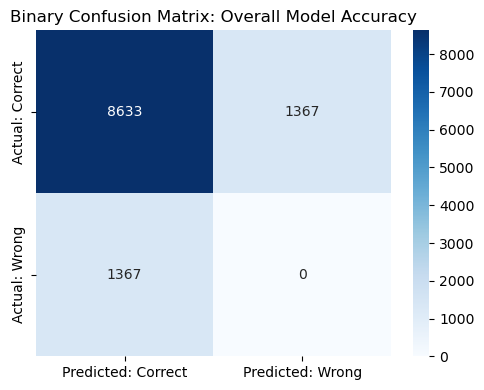

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Build matrix manually
conf_matrix = np.array([[TP, FN],
                        [FP, TN]])

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted: Correct", "Predicted: Wrong"],
            yticklabels=["Actual: Correct", "Actual: Wrong"])
plt.title("Binary Confusion Matrix: Overall Model Accuracy")
plt.tight_layout()
plt.show()
